<a href="https://colab.research.google.com/github/yuvalira/SER-Sinc-Speech-Emotion-Recognition-via-Multi-scale-Sinc-Filters-/blob/main/model%5Cmodel_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SER-Sinc : Speech Emotion Recognition via Multi-scale Sinc Filters**
Yuval Ratzabi - 208414854 , Ratzabiy@post.bgu.ac.il

Gal Zohar - 208788414 , Galzoh@post.bgu.ac.il

Tomer Baziza - 318169158 , baziza@post.bgu.ac.il

Tomer Abram - 208931691 , abram@post.bgu.ac.il

## Imports

In [1]:
import os
import torch
import torchaudio
from torch.utils.data import Dataset
import glob
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import seaborn as sns

## 1. Data Loading and Preprocessing

In [2]:
# Upload kaggle.json API token
from google.colab import files
files.upload()  # Select your kaggle.json file here

# Move kaggle.json to the correct location and set permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the RAVDESS dataset from Kaggle
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

# Unzip the dataset into a folder named 'ravdess_data'
!unzip -q ravdess-emotional-speech-audio.zip -d ravdess_data

# List contents to verify
!ls ravdess_data

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
 90% 388M/429M [00:00<00:00, 421MB/s]
100% 429M/429M [00:00<00:00, 474MB/s]
Actor_01  Actor_06  Actor_11  Actor_16	Actor_21
Actor_02  Actor_07  Actor_12  Actor_17	Actor_22
Actor_03  Actor_08  Actor_13  Actor_18	Actor_23
Actor_04  Actor_09  Actor_14  Actor_19	Actor_24
Actor_05  Actor_10  Actor_15  Actor_20	audio_speech_actors_01-24


In [3]:
class RAVDESSDataset(Dataset):
    def __init__(self, root_dir, sample_rate=16000, duration=3):
        self.root_dir = root_dir
        self.sample_rate = sample_rate
        self.fixed_length = sample_rate * duration
        self.file_paths = glob.glob(os.path.join(root_dir, '**', '*.wav'), recursive=True)
        self.label_map = {
            '01': 0,  # neutral
            '02': 1,  # calm
            '03': 2,  # happy
            '04': 3,  # sad
            '05': 4,  # angry
            '06': 5,  # fearful
            '07': 6,  # disgust
            '08': 7   # surprised
        }

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]

        # Load audio waveform and resample to 16 kHz
        waveform, sr = torchaudio.load(file_path)

        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        if sr != self.sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)
            waveform = resampler(waveform)

        # Trim or pad waveform to fixed length
        if waveform.shape[1] > self.fixed_length:
            waveform = waveform[:, :self.fixed_length]
        elif waveform.shape[1] < self.fixed_length:
            padding = self.fixed_length - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, padding))

        # Extract emotion label from filename
        filename = os.path.basename(file_path)
        emotion_code = filename.split("-")[2]
        label = self.label_map[emotion_code]

        return waveform, label

In [4]:
# Set dataset root path
dataset_path = "ravdess_data/"  # this is where the files were unzipped

# Create dataset instance
full_dataset = RAVDESSDataset(root_dir=dataset_path)
print(len(full_dataset))

2880


Label index: 6
Waveform shape: torch.Size([1, 48000])


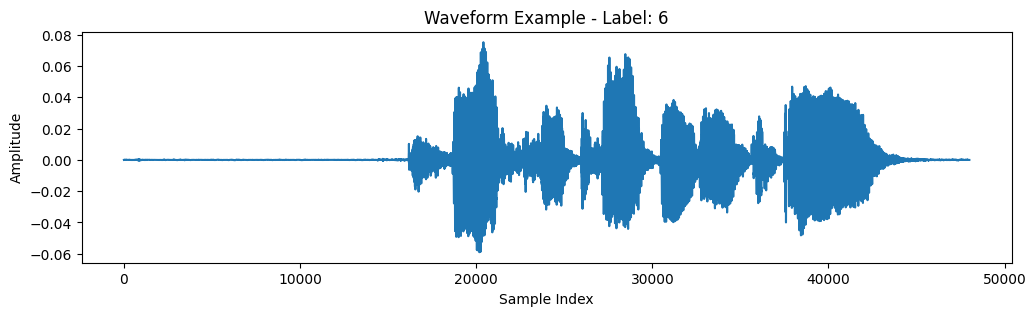

In [5]:
# Visualize one sample from the dataset
waveform, label = full_dataset[0]

print(f"Label index: {label}")
print(f"Waveform shape: {waveform.shape}")  # should be (48000,)

# Plot the waveform
plt.figure(figsize=(12, 3))
plt.plot(waveform.squeeze(0).numpy())
plt.title(f"Waveform Example - Label: {label}")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()

In [6]:
# Total dataset size
total_size = len(full_dataset)

# Split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Compute lengths
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size  # to handle rounding

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # reproducible split
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f"Total samples: {total_size}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Total samples: 2880
Training set size: 2304
Validation set size: 288
Test set size: 288


## 2. Model Architecture: MS-SincResNet
In this section, we define the full MS-SincResNet architecture, adapted for speech emotion recognition (SER). The model consists of a multi-scale SincNet front-end that processes raw audio input, a 2D ResNet-18 backbone for deep feature extraction, a spatial pyramid pooling (SPP) layer to handle variable input lengths, and a final classification head to output one of 8 emotion categories.

This block defines the SincConv layer, which replaces the traditional first convolutional layer with parameterized Sinc filters. These filters act as learnable band-pass filters applied directly to the raw audio waveform.

In [7]:
class SincConv1D(nn.Module):
    def __init__(self, out_channels, kernel_size, sample_rate=16000, in_channels=1, min_low_hz=50, min_band_hz=50):
        super(SincConv1D, self).__init__()

        if in_channels != 1:
            raise ValueError("SincConv1D only supports one input channel.")

        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.sample_rate = sample_rate
        self.min_low_hz = min_low_hz
        self.min_band_hz = min_band_hz

        # Define filter low frequency and band frequency parameters
        low_hz = 30
        high_hz = sample_rate / 2 - (min_low_hz + min_band_hz)
        hz = np.linspace(low_hz, high_hz, out_channels + 1)

        self.low_hz_ = nn.Parameter(torch.Tensor(hz[:-1]))
        self.band_hz_ = nn.Parameter(torch.Tensor(np.diff(hz)))

        # Hamming window
        n_lin = torch.linspace(0, kernel_size - 1, steps=kernel_size)
        self.window = 0.54 - 0.46 * torch.cos(2 * np.pi * n_lin / kernel_size)
        self.n_ = (self.kernel_size - 1) / 2.0
        self.register_buffer('window_', self.window)
        self.register_buffer('n', torch.arange(-self.n_, self.n_ + 1).float())

    def forward(self, x):
        self.n = self.n.to(x.device)
        self.window_ = self.window_.to(x.device)

        low = self.min_low_hz + torch.abs(self.low_hz_)
        high = torch.clamp(low + self.min_band_hz + torch.abs(self.band_hz_), self.min_low_hz, self.sample_rate / 2)

        band = (high - low)[:, None]
        f_times_t_low = torch.matmul(low[:, None], self.n[None, :])
        f_times_t_high = torch.matmul(high[:, None], self.n[None, :])

        band_pass = (torch.sin(2 * np.pi * f_times_t_high) - torch.sin(2 * np.pi * f_times_t_low)) / (self.n[None, :] + 1e-6)
        band_pass = band_pass * self.window_
        band_pass = band_pass / (2 * band)

        filters = band_pass.view(self.out_channels, 1, self.kernel_size)
        return F.conv1d(x, filters, stride=1, padding=self.kernel_size // 2, bias=None, groups=1)

This block defines the multi-scale SincNet front-end, which applies multiple SincConv1D layers with different receptive field sizes (kernel sizes). Each scale captures different frequency resolutions from the raw waveform. The outputs are stacked along the channel dimension to form a multi-channel input for the ResNet backbone.

In [8]:
class MultiScaleSincNet(nn.Module):
    def __init__(self, out_channels_per_scale=20, sample_rate=16000):
        super(MultiScaleSincNet, self).__init__()

        self.sinc_small = SincConv1D(out_channels=out_channels_per_scale, kernel_size=25, sample_rate=sample_rate)
        self.sinc_medium = SincConv1D(out_channels=out_channels_per_scale, kernel_size=75, sample_rate=sample_rate)
        self.sinc_large = SincConv1D(out_channels=out_channels_per_scale, kernel_size=125, sample_rate=sample_rate)

    def forward(self, x):
        # Input x shape: (batch_size, 1, time)
        x_small = self.sinc_small(x)
        x_medium = self.sinc_medium(x)
        x_large = self.sinc_large(x)

        # Stack along the channel dimension
        x_concat = torch.cat([x_small, x_medium, x_large], dim=1)  # shape: (batch, channels*3, time)

        return x_concat

This block implements the Spatial Pyramid Pooling (SPP) layer, which extracts features at multiple spatial scales by applying adaptive max pooling at different levels. This allows the model to aggregate both local and global information and handle variable input lengths.

In [9]:
class SpatialPyramidPooling(nn.Module):
    def __init__(self, pool_sizes=[1, 2, 4]):
        super(SpatialPyramidPooling, self).__init__()
        self.pool_sizes = pool_sizes

    def forward(self, x):
        # Input shape: (batch_size, channels, height, width)
        # Output: concatenated pooled features from each pyramid level
        pooled_outputs = []
        for size in self.pool_sizes:
            pooled = F.adaptive_max_pool2d(x, output_size=(size, size))
            pooled_outputs.append(pooled.view(x.size(0), -1))  # flatten each level
        return torch.cat(pooled_outputs, dim=1)  # shape: (batch, channels * sum(sizes^2))

This block defines the full MS-SincResNet model by combining the multi-scale SincNet front-end, a ResNet-18 feature extractor, a spatial pyramid pooling (SPP) layer, and a fully connected classification head. The output is an 8-class probability distribution corresponding to the emotion categories in the RAVDESS dataset.

In [10]:
class MS_SincResNet(nn.Module):
    def __init__(self, num_classes=8, sample_rate=16000, sinc_channels_per_scale=20):
        super(MS_SincResNet, self).__init__()

        # Multi-scale SincNet front-end
        self.sincnet = MultiScaleSincNet(
            out_channels_per_scale=sinc_channels_per_scale,
            sample_rate=sample_rate
        )

        # Convert 1D output to 2D image format (for ResNet)
        self.expand_dims = lambda x: x.unsqueeze(1)  # (B, C, T) → (B, 1, C, T)

        # Load pretrained ResNet-18 and keep only feature extractor layers
        resnet = resnet18(weights=None)
        print([type(layer) for layer in resnet.children()])  # This will print child layers
        resnet.conv1 = nn.Conv2d(
                      in_channels=1,  # ← we only have one channel (not RGB)
                      out_channels=64,
                      kernel_size=7,
                      stride=2,
                      padding=3,
                      bias=False
                  )
        self.resnet = nn.Sequential(*list(resnet.children())[:-2])  # up to layer4

        # Add SPP layer to extract multiscale features
        self.spp = SpatialPyramidPooling(pool_sizes=[1, 2, 4])

        # Classifier head after SPP
        resnet_output_dim = 512 * (1 + 4 + 16)  # 512 × sum(pool_sizes^2)
        self.classifier = nn.Sequential(
            nn.Linear(resnet_output_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
      # x: (B, 1, T)
      x = self.sincnet(x)         # (B, 60, T)
      x = x.unsqueeze(1)          # (B, 1, 60, T)
      x = F.interpolate(x, size=(60, 160))  # (B, 1, 60, 160)
      x = self.resnet(x)          # Should be (B, 512, H, W)
      x = self.spp(x)             # Vector
      out = self.classifier(x)    # (B, 8)

      return out



In this step, we instantiate the MS-SincResNet model and test a forward pass using a dummy waveform input. This verifies that all layers are correctly connected and that the output shape matches the expected number of emotion classes.

In [11]:
# Instantiate model
model = MS_SincResNet(num_classes=8, sample_rate=16000)
model.eval()  # Set model to evaluation mode

# Create dummy input: batch size 1, 1 channel, 3 seconds at 16 kHz = 48000 samples
dummy_waveform = torch.randn(1, 1, 48000)

# Forward pass
with torch.no_grad():
    output = model(dummy_waveform)

# Print output shape and values
print(f"Output shape: {output.shape}")  # Expected: (1, 8)
print("Output logits:", output)

[<class 'torch.nn.modules.conv.Conv2d'>, <class 'torch.nn.modules.batchnorm.BatchNorm2d'>, <class 'torch.nn.modules.activation.ReLU'>, <class 'torch.nn.modules.pooling.MaxPool2d'>, <class 'torch.nn.modules.container.Sequential'>, <class 'torch.nn.modules.container.Sequential'>, <class 'torch.nn.modules.container.Sequential'>, <class 'torch.nn.modules.container.Sequential'>, <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>, <class 'torch.nn.modules.linear.Linear'>]
Output shape: torch.Size([1, 8])
Output logits: tensor([[-0.0570, -0.0438,  0.0400,  0.0199, -0.0221,  0.0504,  0.0495, -0.0069]])


## 3. Model Training and Evaluation
In this section, we define the training loop, loss function, optimizer, and evaluation metrics for training the MS-SincResNet model on the RAVDESS dataset. The model will be trained using raw audio waveforms and validated on a separate validation split to monitor performance and detect overfitting.

In [12]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [13]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for waveforms, labels in dataloader:
        waveforms, labels = waveforms.to(device), labels.to(device)

        # Add channel dimension if missing
        if waveforms.ndim == 2:
            waveforms = waveforms.unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(waveforms)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    return avg_loss, acc

In [14]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for waveforms, labels in dataloader:
            waveforms, labels = waveforms.to(device), labels.to(device)

            if waveforms.ndim == 2:
                waveforms = waveforms.unsqueeze(1)

            outputs = model(waveforms)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    return avg_loss, acc

In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10, patience=3):
    model.to(device)
    best_val_acc = 0.0
    best_model_state = None
    epochs_since_improvement = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        start_time = time.time()

        # === Train ===
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []

        for waveforms, labels in train_loader:
            waveforms, labels = waveforms.to(device), labels.to(device)
            if waveforms.ndim == 2:
                waveforms = waveforms.unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(waveforms)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_loss = total_loss / len(train_loader)
        train_acc = accuracy_score(all_labels, all_preds)

        # === Validation ===
        model.eval()
        total_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for waveforms, labels in val_loader:
                waveforms, labels = waveforms.to(device), labels.to(device)
                if waveforms.ndim == 2:
                    waveforms = waveforms.unsqueeze(1)

                outputs = model(waveforms)
                loss = criterion(outputs, labels)

                total_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss = total_loss / len(val_loader)
        val_acc = accuracy_score(all_labels, all_preds)

        # Store history
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Check for improvement
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            epochs_since_improvement = 0
        else:
            epochs_since_improvement += 1

        # Print epoch summary
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
              f"Time: {time.time() - start_time:.1f}s")

        # Early stopping check
        if epochs_since_improvement >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    # Plot learning curves
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, val_losses, label="Validation Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
    plt.plot(epochs_range, val_accuracies, label="Validation Accuracy")
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return best_model_state

Before training, we verify that the DataLoaders return correctly shaped inputs and labels. We check the waveform tensor dimensions, ensure batch shape is valid, and confirm labels are properly extracted.

Waveforms shape: torch.Size([8, 1, 48000])
Labels shape: torch.Size([8])
First waveform length: torch.Size([1, 48000])
First label: tensor(3)


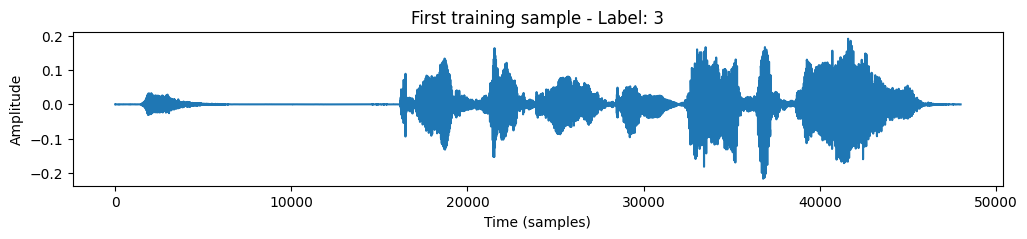

In [16]:
# Get one batch from train_loader
batch = next(iter(train_loader))
waveforms, labels = batch

print("Waveforms shape:", waveforms.shape)  # Expected: (B, 1, 48000)
print("Labels shape:", labels.shape)        # Expected: (B,)

# Show first waveform length and first label
print("First waveform length:", waveforms[0].shape)
print("First label:", labels[0])

# Plot the first waveform (optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 2))
plt.plot(waveforms[0].squeeze(0).numpy())
plt.title(f"First training sample - Label: {labels[0].item()}")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.show()

Epoch 1/20 | Train Loss: 2.0290, Train Acc: 0.2053 | Val Loss: 1.9602, Val Acc: 0.2674 | Time: 64.1s
Epoch 2/20 | Train Loss: 1.8874, Train Acc: 0.2509 | Val Loss: 1.7602, Val Acc: 0.3125 | Time: 55.7s
Epoch 3/20 | Train Loss: 1.7883, Train Acc: 0.2956 | Val Loss: 1.7357, Val Acc: 0.3542 | Time: 55.5s
Epoch 4/20 | Train Loss: 1.6654, Train Acc: 0.3338 | Val Loss: 1.5875, Val Acc: 0.4097 | Time: 54.8s
Epoch 5/20 | Train Loss: 1.5267, Train Acc: 0.4067 | Val Loss: 1.5228, Val Acc: 0.4410 | Time: 55.7s
Epoch 6/20 | Train Loss: 1.3475, Train Acc: 0.4813 | Val Loss: 1.5067, Val Acc: 0.4653 | Time: 54.8s
Epoch 7/20 | Train Loss: 1.1928, Train Acc: 0.5464 | Val Loss: 1.1448, Val Acc: 0.5938 | Time: 55.4s
Epoch 8/20 | Train Loss: 0.9816, Train Acc: 0.6341 | Val Loss: 1.1148, Val Acc: 0.5903 | Time: 55.4s
Epoch 9/20 | Train Loss: 0.8163, Train Acc: 0.6923 | Val Loss: 0.8888, Val Acc: 0.6944 | Time: 55.4s
Epoch 10/20 | Train Loss: 0.6982, Train Acc: 0.7500 | Val Loss: 0.7222, Val Acc: 0.7674 | T

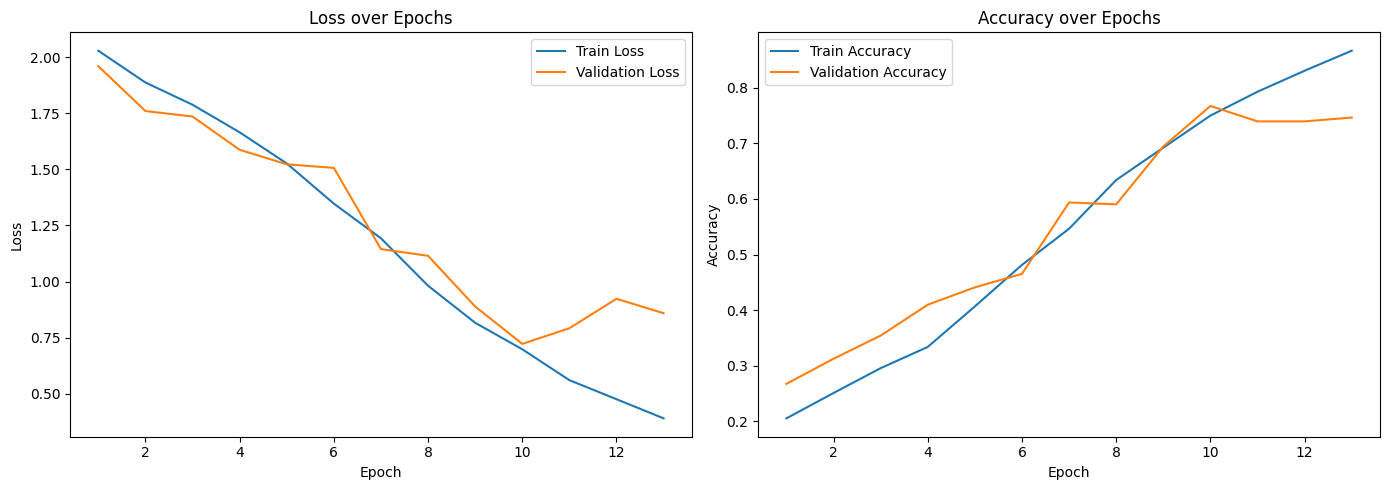

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_state = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device=device,
    epochs=20,
    patience=3  # stop if no improvement for 5 epochs
)


📄 Classification Report:

              precision    recall  f1-score   support

     neutral     0.8125    0.5417    0.6500        24
        calm     0.6667    0.7179    0.6914        39
       happy     0.8571    0.8333    0.8451        36
         sad     0.5849    0.7750    0.6667        40
       angry     0.8837    0.8261    0.8539        46
     fearful     0.8571    0.7895    0.8219        38
     disgust     0.8667    0.7222    0.7879        36
   surprised     0.7059    0.8276    0.7619        29

    accuracy                         0.7639       288
   macro avg     0.7793    0.7542    0.7598       288
weighted avg     0.7800    0.7639    0.7661       288



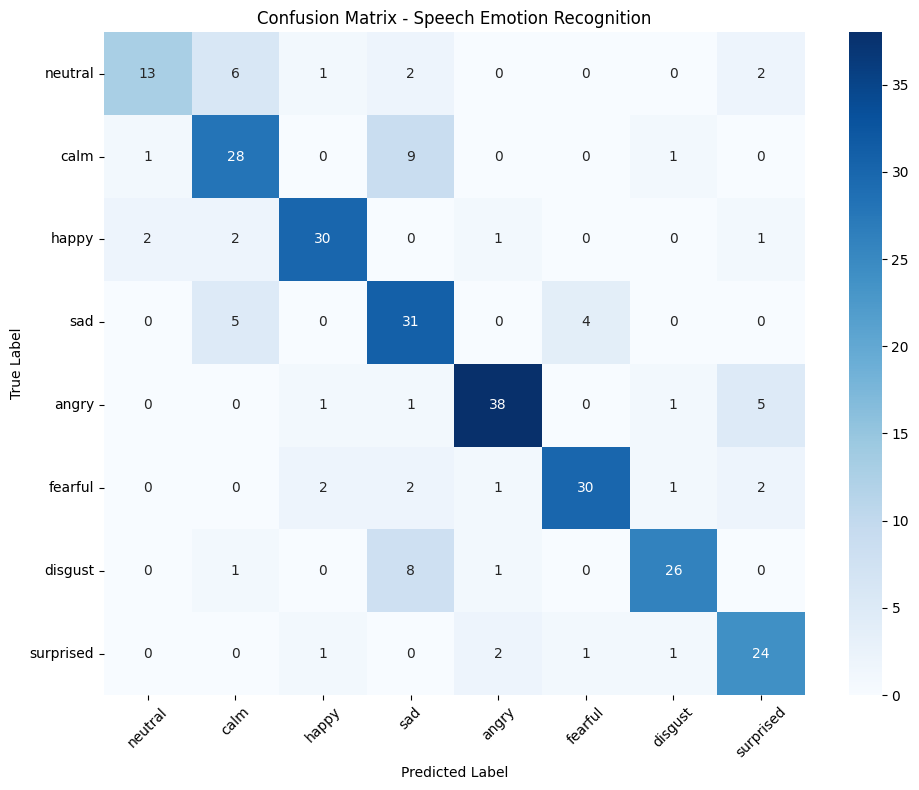

In [18]:

# === Defining label names (in numerical order in the dataset) ===
label_names = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

# === Traverse the test set and collect predictions and true labels ===
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for waveforms, labels in test_loader:
        waveforms, labels = waveforms.to(device), labels.to(device)

        if waveforms.ndim == 2:
            waveforms = waveforms.unsqueeze(1)

        outputs = model(waveforms)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# === Detailed report for each emotion ===
print("\n📄 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=label_names, digits=4))

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Speech Emotion Recognition")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [20]:
from google.colab import drive
drive.mount('/content/drive')

# Save to Drive
torch.save(best_state, "/content/drive/MyDrive/best_model.pth")

Mounted at /content/drive
